In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import pymc3 as pm
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
from IPython.display import Math, Latex

# Loss functions
If you think these ROPE rules sound a little bit clunky and you want something more formal, loss functions are what you are looking for! To make a good decision, it is important to have the highest possible level of precision for the estimated value of the relevant parameters, but it is also important to take into account the cost of making a mistake. The cost/benefit trade-off can be mathematically formalized using loss functions. The names for loss functions or its inverses vary across different fields, and we could find names such as cost functions, objective functions, fitness functions, utility functions, and so on. No matter the name, the key idea is to use a function that captures how different the true value and the estimated value of a parameter are. The larger the value of the loss function, the worse the estimation is (according to the loss function). Some common examples of loss functions are:

In [30]:
display(Math(r'quadratic \ loss: \ (\theta - \hat{\theta})^2'))
display(Math(r'absolute \ loss: \ | \ \theta - \hat{\theta} \ |'))
display(Math(r'0-1 \ loss : \ I(\theta \ne \hat{\theta} ), \ where \ I \ is  \ the \ indicator \ function'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Great article on different kinds of loss functions including Huber Loss:
https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

In [35]:
# same model as coin flipping model found in 'programming probablistically'
data = stats.bernoulli.rvs(p=0.35, size=4)
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5097.50draws/s]
The acceptance probability does not match the target. It is 0.883213931388288, but should be close to 0.8. Try to increase the number of tuning steps.


In practice, we generally do not have the value of the true parameter theta at hand. Instead, we have an estimation in the form of a posterior distribution. Thus, what we can do is find out the value of theta that minimizes the expected loss function. By expected loss function, we mean the loss function averaged over the whole posterior distribution. In the following block of code, we have two loss functions: the absolute loss (lossf_a) and the quadratic loss (lossf_b). We will explore the value of  over a grid of 200 points. We will then plot those curves and we will also include the value of  that minimizes each loss function:

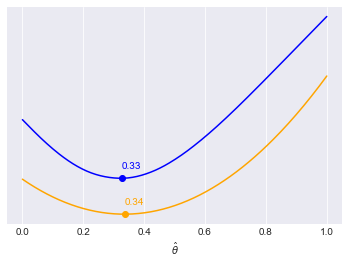

In [38]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['blue', 'orange']): #alternate colors ['C0', 'C1']
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

As we can see, the result looks somewhat similar for lossf_a is 0.33 and lossf_b is 0.34. What is interesting from this result is that the first value is equal to the median of the posterior and the last value is equal to the mean of the posterior. You can check this for yourself by computing np.mean(θ_pos), np.median(θ_pos). I know this is no formal proof, but the take home message is this: different loss functions are related to different point-estimates.

OK, so if we want to be formal and we want to compute a single point-estimate, we must decide which loss function we want, or in reverse, if we choose a given point-estimate, we are implicitly (and maybe even unconsciously) deciding on a loss function. The advantage of explicitly choosing a loss function is that we can tailor the function to our problem, instead of using some predefined rule that may not be suitable in our particular case. For example, in many problems, the cost of making a decision is asymmetric; it is not the same to decide whether it is safe or not to administrate a vaccine to children under five and being right, that being wrong. Making a bad decision could cost thousands of lives and produce a health crisis that could have being avoided by administrating a cheap and safe vaccine. Thus, if our problem demands it, we can construct an asymmetric loss function. It also important to notice that, as the posterior is in the form of numerical samples, we can compute complex loss functions that don't need to be restricted by mathematical convenience or mere simplicity.

For example:

Text(0.5, 0, '$\\hat \\theta$')

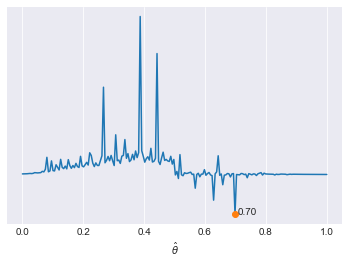

In [39]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

All this being said, I would like to clarify a point. It is not true that every time people uses a point-estimate they are truly thinking in terms of loss functions. In fact, loss functions are not very common in many of the scientific fields I am more or less familiar with. People often choose the median, just because it is more robust to outliers than the mean, or use the mean just because is a simple and familiar concept, or because they think their observable is truly the average of some process at some level, like molecules bouncing to each other or genes interacting with themselves and the environment.

We just saw a very brief and superficial introduction to loss functions. If you want to learn more about this, you can try reading about decision theory, the field that study formal decision making.